For this notebook, we are going to use the following libraries:
- `numpy`: To help us build and work with matrices.
- `scipy`: Because they have a very useful function to solve the eigenvalue problem for hermitian matrices (`eigh`).
- `plotly`: To plot fast, beautiful and interactive plots.
- `sisl`: To plot the structures.

In [ ]:
import numpy as np
import plotly.graph_objs as go
import plotly.express as px
from scipy.linalg import eigh
import sisl
import sisl.viz

You already used the tight binding model to calculate some simple models analitically. You probably have already noticed that once problems get bigger and interactions become more complex, solving them "by hand" becomes prohibitive.

That's why those systems are solved numerically with the help of a computer. In this tutorial we are going to learn how to implement a tight binding model for two cases:
- A biatomic 1D chain, which you already solved analitically.
- Graphene.

Biatomic 1D tight binding
-------

You have already thought about this system, so we will use it as our example. It is simply a 1D chain of build with two different atoms. So, the unit cell contains two atoms, and the system looks something like this: 

In [ ]:
a = 1.3
geometry = sisl.Geometry([[0, 0, 1.5], [a, 0, 1.5]], atoms=["H", "N"], sc=[2 * a, 3, 3])

geometry.plot(
    axes="xz", atoms_scale=3, nsc=[4,1,1],
).update_traces(
    selector={"name": "Atoms"}, mode="markers+text", textposition="top center", text=["0", "1"] * 4
).update_layout(title="Biatomic 1D chain")

In a tight binding of this system, assuming we **only use one orbital per atom**, our hamiltonian ($H$) and overlap ($S$) matrices for a given $\textbf{k}$ vector ($H_k, S_k$) will be of shape $2x2$. Since we only compute **interactions with first neighbors**, there are only 5 parameters that define our model:
- `a`: The lattice vector in the periodic direction (in this case `a` is just a distance because we only care about 1 dimension).
- `onsite_0` ($e_0$): The onsite energy of atom 0 (and all its periodic images).
- `onsite_1` ($e_1$): The onsite energy of atom 1 (and all its periodic images).
- `gamma` ($\gamma$): The interaction term between orbitals 0 and 1 (hopping). This will determine the non-diagonal terms of the hamiltonian matrix ($H_k$). 
- `overlap` ($s$): The overlap between orbitals 0 and 1. This will determine the non-diagonal terms of the overlap matrix ($S_k$)

Let's go step by step. We will define some values here for all our parameters:

In [ ]:
a = 2.6 
onsite_0 = 0.1
onsite_1 = -0.1
gamma = -2.84
overlap = 0.01

And think about how, for a given $\textbf{k}$, we will calculate our matrices. As we mentioned before, our $H_k$ matrices will be $2x2$ because we only have 2 orbitals per unit cell. So they will look like this:

$$
H_k = 
\begin{bmatrix}
H^{00}_k & H^{10}_k\\[0.3em]
H^{01}_k & H^{11}_k\\[0.3em]
\end{bmatrix}
$$

Now, to calculate each matrix element, we just have to **sum the interaction terms between orbital $i$ and all the periodic images of $j$**, multiplying each term by the appropiate phase.

$$
H^{ij}_k = \sum_{R} H_{ij_R}e^{-i kR}
$$

where the sum is over all the relevant cells (each located at a position $R$) and $e^{-i kR}$ is the phase for the contributions of that particular cell.

For our particular case, we will go term by term and think about each element. Let's start thinking about the interaction of the first atom with himself ($H^{00}_k$). Since atom `0` doesn't interact with any periodic image of himself, there's only the contribution from the unit cell ($R=0$):

$H^{00}_k = e_0 e^{-ik\times0} = e_0$

The same applies for the interaction of the atom `1` with himself.

$H^{11}_k = e_1$

Let's now think about the interaction of atom `0` with `1`. There are two images of the atom `1` that are first neighbors of `0`, and therefore interact with a term $\gamma$: One in the unit cell ($R=0$) and another one one cell to the left ($R = -a$).

$H^{01}_k = \gamma e^{-ik\times0} + \gamma e^{-ik\times(-a)}= \gamma + \gamma e^{ika} = \gamma (1 + e^{ika})$

And the interaction of `1` with `0` is basically the same but in this case the images of `0` that are first neighbors are in the unit cell ($R=0$) and the cell to the right ($R = a$).

$H^{10}_k = \gamma e^{-ik\times0} + \gamma e^{-ika}= \gamma + \gamma e^{-ika} = \gamma (1 + e^{-ika}) $

To sum up, the $H_k$ matrices that we will need to build are:
 
$$
H_k = 
\begin{bmatrix}
e_0 & \gamma(1 + e^{ika})\\[0.3em]
\gamma(1 + e^{-ika}) & e_1\\[0.3em]
\end{bmatrix}
$$

And similarly, for the overlap matrices:

$$
S_k = 
\begin{bmatrix}
1 & s(1 + e^{ika})\\[0.3em]
s(1 + e^{-ika}) & 1\\[0.3em]
\end{bmatrix}
$$

**NOTE**: $1 + e^{ika}$ is the complex conjugate of $1 + e^{-ika}$, so **the matrices are hermitian** (as they should!).

So, here's the code that we will need to calculate $H_k$ and $S_k$:

In [ ]:
# The k value for which we want to calculate the matrices:
k = 0

# We define the matrices just as they are described above
H_k = np.array([
    [onsite_0, gamma * (1 + np.exp(1j*k*a))],
    [gamma * (1 + np.exp(-1j*k*a)), onsite_1]
])

S_k = np.array([
    [1, overlap * (1 + np.exp(1j*k*a))],
    [overlap * (1 + np.exp(1j*k*a)), 1]
])

And then we could calculate the eigenvalues for them using the `eigh` from `scipy`. 

In [ ]:
# Calculate the eigenvalues (energies, 2 values) and eigenvalues (states, 2 states with 2 coefficients each)
eigh(H_k, S_k, lower=False)

This routine **assumes that the matrix is hermitian**, and therefore only uses one triangle of the matrix to save memory and time. You can choose whether the "upper" or the "lower" triangle is used. This means that **you don't actually need to calculate all the elements of the matrices**, just the ones being used!

Since we decide to use the upper triangle (`lower=False`), we can actually define our matrices like this (much cleaner):

In [ ]:
# Calculate the total phase for the 01 interaction
phase = 1 + np.exp(1j*k*a)

# And define the matrices.
H_k = np.array([
    [onsite_0, gamma * phase],
    [0, onsite_1]
])

S_k = np.array([
    [1, overlap * phase],
    [0, 1]
])

And we would get exactly the same results:

In [ ]:
eigh(H_k, S_k, lower=False)

Note however that this way of building the matrices $H_k$ and $S_k$ **is not flexible at all**!! It is only valid for **this particular system and with only first neighbor interactions**. If you want to write a more reusable tight binding code, you might have probably build a list of neighbours and **perform the sum inside the code** by looping through this list.

### Calculating the band structure

Once we know how to build the matrices, our first goal is to **calculate the band structure of the system**. The band structure is nothing more than the eigenvalues obtained by solving $S_k^{-1}H_k\phi = E_k\phi$ for each $\textbf{k}$ of the path that we are interested in. In this case, since there's only periodicity in 1 direction, the only interesting path will be from Gamma ( $\textbf{k}= (0, 0, 0)$ ) to the end of the first Brillouin Zone ( $\textbf{k} = (\pi/a, 0, 0) $ ).

So, we will now define a function that calculates the band structure just by looping through all the k points required. We will need to prepare a numpy array to store all the eigenvalues and fill it as we loop.

In [ ]:
def biatomic_chain_bands(a, nkpoints, onsite_0=0.1, onsite_1=-0.1, gamma=-2.84, overlap=0.01):
    """Function that implements the tight binding model for a biatomic chain.
    
    It uses only the first neighbours approximation, and only one orbital per
    atom is considered.
    
    The path used for the bands is Gamma ([0,0,0]) to X ([pi/a, 0, 0]).
    
    Parameters
    ----------
    a: float
        Size of the cell (in Ang)
    nkpoints: int
        Number of k points that the path should contain.
        Points will be uniformly distributed.
    onsite_0: float, optional
        Onsite energy for atom 0 (in eV).
    onsite_1: float, optional
        Onsite energy for atom 1 (in eV).
    gamma: float, optional
        Hopping term between first neighbors.
    overlap: float, optional
        Overlap term between first neighbors.
        
    Returns
    -------
    np.array of shape (nkpoints, )
        The k values used for the path (only the X component of the k vector is returned).
    np.array of shape (nkpoints, 2)
        The energies of the eigenstates for the whole path (in eV). 
        Each row (k point) contains two eigenvalues.
    """
    # Get all the k values that we are going to use.
    ks = np.linspace(0, np.pi/a, nkpoints)
    # Initialize the eigenvalues array, where we will store everything.
    eigenvalues = np.zeros((nkpoints, 2))

    # We can start looping through all the K points to get the eigenvalues for each of them.
    for i, k in enumerate(ks):
        # For each k point, we basically do what we had defined previously
        phase = 1 + np.exp(1j*k*a)
        
        H_k = np.array([
            [onsite_0, gamma * phase],
            [0, onsite_1]
        ])

        S_k = np.array([
            [1, overlap * phase],
            [0, 1]
        ])

        # Finally, diagonalize and extract the eigenvalues.
        k_eigenvalues, k_eigenvecs = eigh(H_k, S_k, lower=False)
        # And store them in our array.
        eigenvalues[i, :] = k_eigenvalues
    
    # We are done looping, just return our results
    return ks, eigenvalues

We can now execute this function and we would get both the ks used and the energies obtained for each k:

In [ ]:
# Let's do only 5 k points for now to visualize the output easily
biatomic_chain_bands(2.6, 5)

See how we get the 5 k values used, and array containing, for each k point, 2 energy values.

The only thing that we need now to plot the bands is storing the results

In [ ]:
k, E = biatomic_chain_bands(2.6, 500)

And displaying them

In [ ]:
fig = go.Figure()
for vals in E.T:
    fig.add_scatter(x=k, y=vals)
fig

Notice how you might as well have defined a function to directly plot the bands. Having the ks and eigenvalues is useful to do other analysis though.

We can, for example, plot an histogram of the states:

In [ ]:
px.histogram(E, nbins=400)

**Questions**: Which property does this plot represent? How could we make it smoother?

Graphene tight binding
-------

Now that we have understood how to code a tight binding for the 1D biatomic chain, we will move to a slightly more complex, but more interesting case: graphene.

Graphene has a 2D honeycomb lattice, which will make our $\textbf{k}$ and $\textbf{R}$ vectors instead of scalars.

Here's a sketch of the graphene system:

In [ ]:
geom = sisl.geom.graphene()
geom.plot(
    axes="xy", nsc=[2,2,1], atoms_scale=3, atoms_style={"color": ["gray", "blue"]}
).update_traces(
    selector={"name": "Atoms"}, mode="markers+text", textposition="top center", text=["0", "1"] * 4
).update_layout(title="Graphene")

Using the experience from the previous case, you should now implement a function to calculate the bands for graphene and then plot them.

For reference, here's graphene's lattice (a) and reciprocal lattice (b):
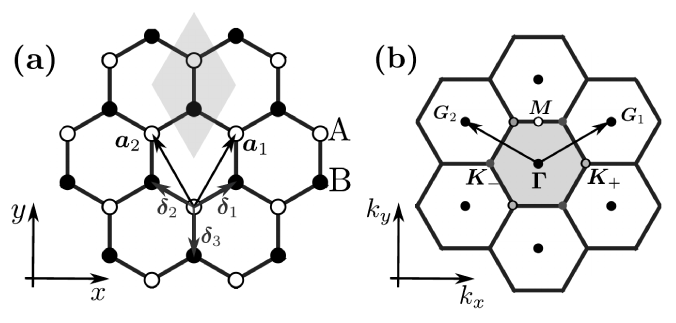

The most common path for the band structure of graphene is: $\Gamma > M > K$

Try to follow the same thought process that we used in the 1D chain, but this time for graphene. Following, we provide you with a skeleton of the function that you must implement:

In [ ]:
def graphene_bands(...):
    """Explain your function in one line
    
    Maybe provide extra info here?
    
    Parameters
    ----------
    Document what each parameter does.
        
    Returns
    -------
    Document what the function returns
    """
    # Somehow, get all the k values that you need for the path
    ks = ...
    # Initialize the eigenvalues array, where we will store everything.
    # You need to figure out which shape should this array have
    eigenvalues = np.zeros(...)

    # Then loop through all the k points
    for i, k in enumerate(ks):
        # Somehow build the hamiltonian and overlap matrices for that k point
        # You can think about this in a different cell to test your implementation.
        H_k = ...
        S_k = ...

        # Finally, diagonalize and extract the eigenvalues.
        k_eigenvalues, k_eigenvecs = eigh(H_k, S_k, lower=False)
        # And store them in our array.
        eigenvalues[i, :] = k_eigenvalues
    
    # We are done looping, just return our results
    return ks, eigenvalues

Once your function works, plot the bands and see if you get the dirac cone!

**Bonus points**: You could reuse this function by slightly modyfing it to calculate **h-BN** instead of **graphene**.

**Bonus points (2)**: Sample a 2D space of k values to get their eigenvalues. Then you can plot a 2D band structure, which looks very nice. See [here](https://plotly.com/python/3d-surface-plots/) to understand how to plot a surface with plotly.